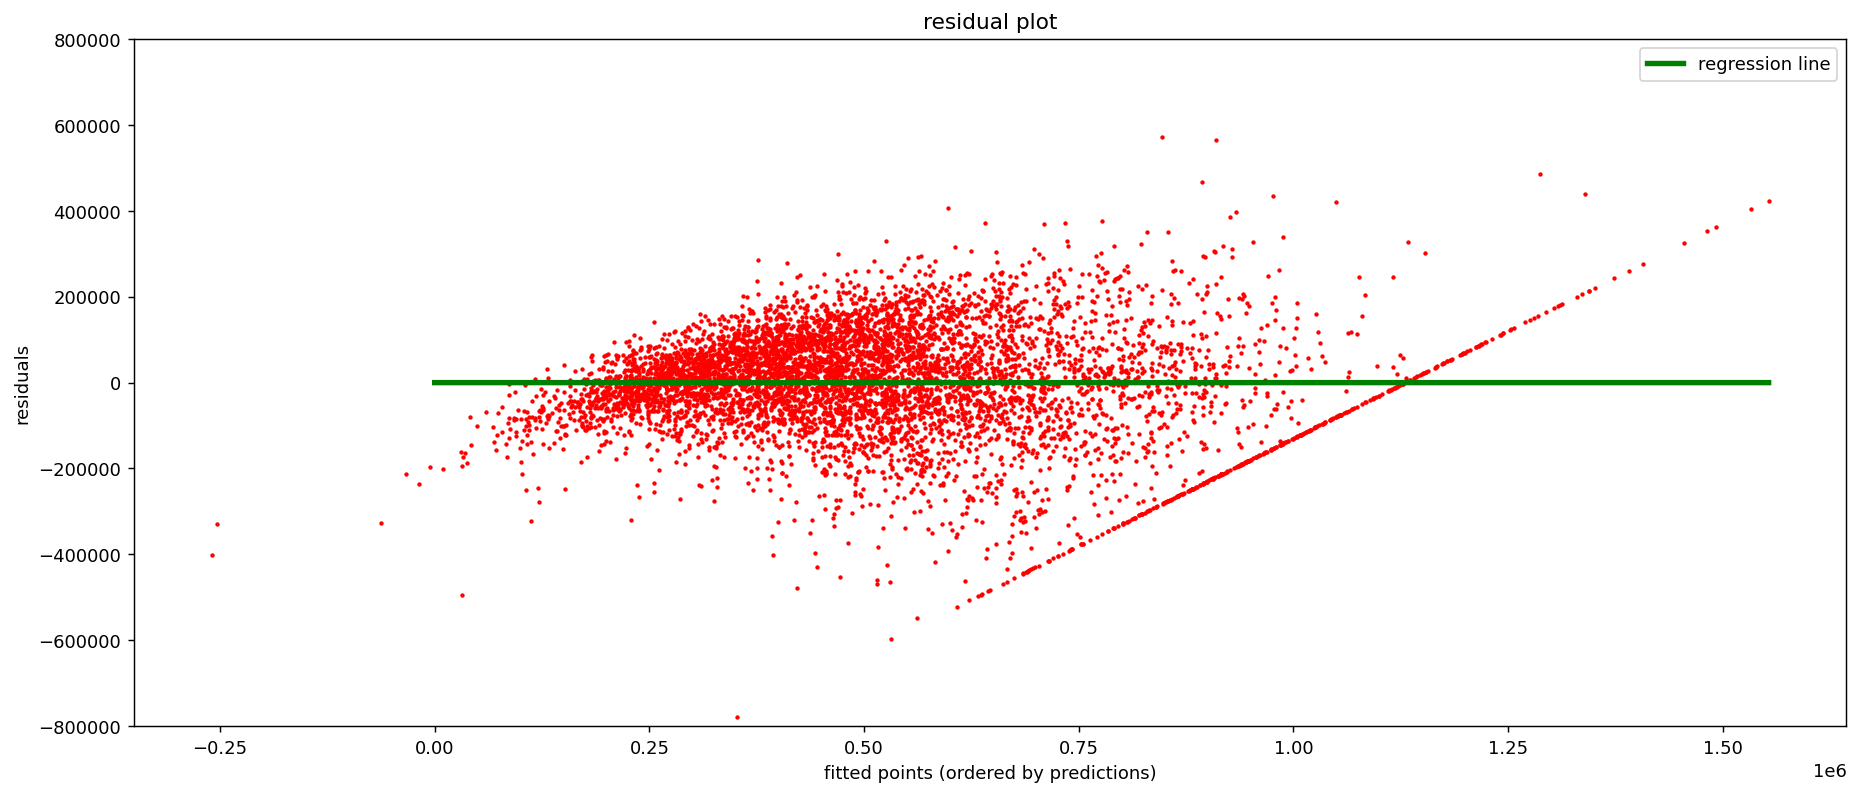

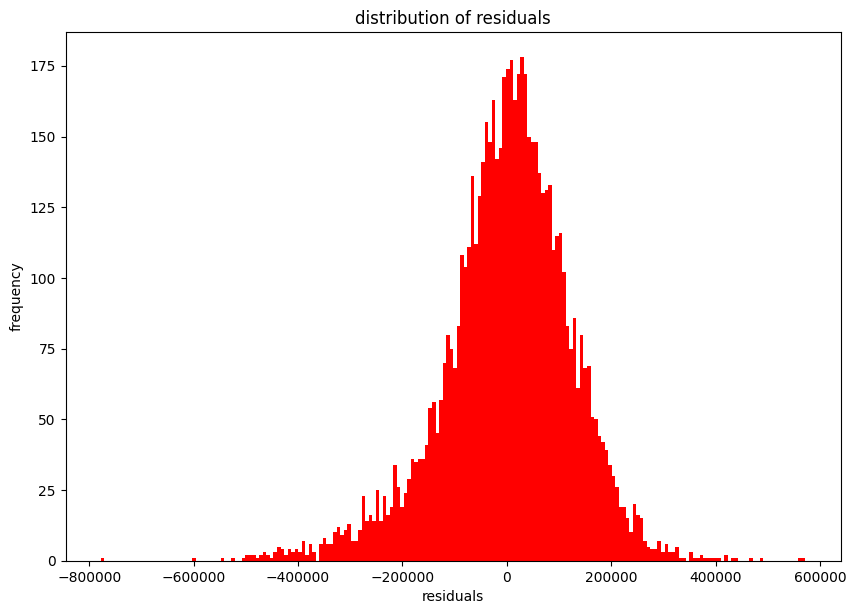

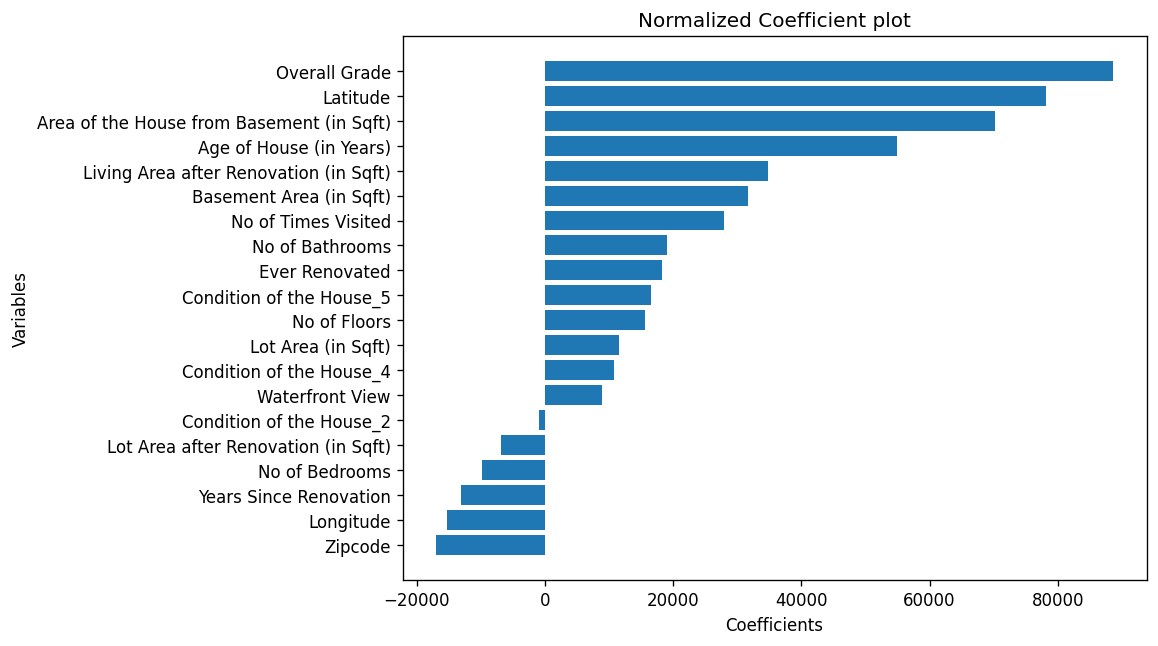

In [19]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

data=pd.read_csv("E:\Price prediction ML\Raw_Housing_Prices.csv")

# ------ Treating Outliers ------------
q1=data["Sale Price"].quantile(0.25)
q3=data["Sale Price"].quantile(0.75)
iqr=q3-q1

l_limit= q1-1.5*iqr
u_limit= q3+1.5*iqr

def value_limiter(value):
    if value > u_limit:
       return u_limit
    if value < l_limit:
        return l_limit
    else:
       return value
data["Sale Price"]=data["Sale Price"].apply(value_limiter)

# -------- Teating Missing Value of Target variable ------------

data.dropna(axis=0, subset=["Sale Price"], inplace=True)

# -------- Treating Missing Value of Numerical variable --------

numerical_variables=['No of Bathrooms', 'Flat Area (in Sqft)','Lot Area (in Sqft)',
                     'Area of the House from Basement (in Sqft)','Latitude',
                     'Longitude','Living Area after Renovation (in Sqft)']

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
data[numerical_variables] = imputer.fit_transform(data[numerical_variables])

column=data["Zipcode"].values.reshape(-1,1)
imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
data['Zipcode'] = imputer.fit_transform(column)

# ------------ Categorical to Numerical column Conversion --------
mapping = {'None' : "0",
           'Once' : '1',
           'Twice' : '2',
           'Thrice' : '3',
           'Four' : '4'}

data['No of Times Visited'] = data['No of Times Visited'].map(mapping)

# ---------- Variable Transformation -----------

data["Ever Renovated"]= np.where(data["Renovated Year"]==0 , "No", "Yes")
data["Purchase Year"]= pd.DatetimeIndex(data["Date House was Sold"]).year
data['Years Since Renovation'] = np.where(data["Ever Renovated"] == 'Yes',
                                                     abs(data["Purchase Year"] - data["Renovated Year"]), 0)

data.drop(columns=["Date House was Sold","Purchase Year", "Renovated Year"], inplace=True)
data.drop(columns="ID", inplace=True)

# ------------- Seperating Dependent and Independent ---------------

X=data.drop(columns=["Sale Price"])
Y=data["Sale Price"]

# ----------- Categorical To Numerical ( Independent Variable) ------------

X["Waterfront View"] = X["Waterfront View"].map({ "No":0,"Yes":1
})


X["Condition of the House"] = X["Condition of the House"].map({'Bad':1,
                                                                'Okay':2,
                                                                'Fair':3,
                                                                'Good':4,
                                                                'Excellent':5
})

X["Ever Renovated"] = X["Ever Renovated"].map({"No":0,"Yes":1 })


#----------- Dummy variables---------------

X=pd.get_dummies(X, columns=["Condition of the House"], drop_first=True)

# ----------- Scaling Independent Variables --------------

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
Y=data["Sale Price"]
X1= scaler.fit_transform(X)
X=pd.DataFrame(data=X1, columns=X.columns)

# ------- Correlation --------------------------------
K=X.corr()
Z = [[str(i),str(j)] for i in K.columns for j in K.columns if (K.loc[i,j] > abs(0.5))&(i!=j)]

#---------------- Variance Inflation factor ------------------

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data=X

VIF = pd.Series([variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])], index = vif_data.columns)

def MC_remover(data):
  vif = pd.Series([variance_inflation_factor(data.values, i) for i in range(data.shape[1])], index = data.columns)
  if vif.max() > 5:
    data = data.drop(columns = [vif[vif == vif.max()].index[0]]) 
    return data
  else:
    return data

for i in range(7):                 
  vif_data = MC_remover(vif_data) 
  
# ----------- VIF for Other variables ---------------
VIF = pd.Series([variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])], index = vif_data.columns)
X = vif_data
Y = data['Sale Price']


# ------------ Creating Train, Test Dataset -------------

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 101) 

from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize = True)
lr.fit(x_train, y_train)

predictions = lr.predict(x_test)
r_square=lr.score(x_test,y_test)

residuals = predictions - y_test
 
residual_table = pd.DataFrame({'residuals': residuals,'predictions':predictions})
residual_table = residual_table.sort_values( by = 'predictions')

z = [i for i in range(int(residual_table['predictions'].max()))]   
k = [0 for i in range(int(residual_table['predictions'].max()))]  

plt.figure(dpi = 130, figsize = (17,7))

plt.scatter( residual_table['predictions'], residual_table['residuals'], color = 'red', s = 2)
plt.plot(z, k, color = 'green', linewidth = 3, label = 'regression line')
plt.ylim(-800000, 800000)
plt.xlabel('fitted points (ordered by predictions)')
plt.ylabel('residuals')
plt.title('residual plot')
plt.legend()
plt.show()

#  -------------- Graph2 - Distribution of Residuals ----------------

plt.figure(dpi = 100, figsize = (10,7))
plt.hist(residual_table['residuals'], color = 'red', bins = 200)
plt.xlabel('residuals')
plt.ylabel('frequency')
plt.title('distribution of residuals')
plt.show()

# --------------- Graph3 -------------------
coefficients_table = pd.DataFrame({'column': x_train.columns,'coefficients': lr.coef_})
coefficient_table = coefficients_table.sort_values(by = 'coefficients')

plt.figure(figsize=(8, 6), dpi=120)
x = coefficient_table['column']
y = coefficient_table['coefficients']
plt.barh( x, y)
plt.xlabel( "Coefficients")
plt.ylabel('Variables')
plt.title('Normalized Coefficient plot')
plt.show()




In [20]:
# data.info()
# column.shape
# data['Years Since Renovation']
# X["Condition of the House"]
r_square

0.7561570342011642